In [1]:
import math
import numpy as np
import pandas as pd
import scipy as sc
import matplotlib.pyplot as plt
from scipy.integrate import quad, trapz

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
red_4_28 = pd.read_csv('../B(GT) peaks processing/recognition/red data/4_28_red.csv', 
                      sep='\t', decimal=',')

In [4]:
red_4_28.head()

,x,y
0,4.019953,0.806074
1,4.033255,0.894327
2,4.046557,0.956623
3,4.059859,1.179850
4,4.073161,1.397886


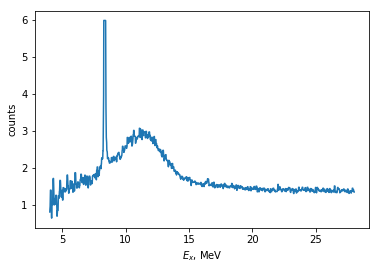

In [5]:
plt.plot(red_4_28['x'].values, red_4_28['y'].values)
plt.xlabel('$E_x$, MeV')
plt.ylabel('counts')

In [8]:
def gauss(x, mu, sigma):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sigma, 2.)))

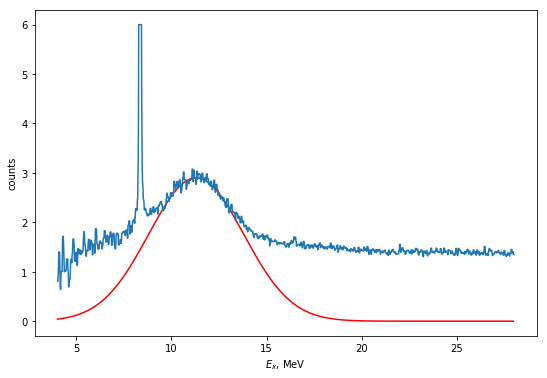

In [24]:
x = np.arange(4, 28, 0.01)
y = 2.9 * gauss(x, 11.3, 2.5)
plt.figure(figsize=(9,6))
plt.plot(x, y, c='r')
plt.plot(red_4_28['x'].values, red_4_28['y'].values)
plt.xlabel('$E_x$, MeV')
plt.ylabel('counts')

In [25]:
trapz(4.44*y, x)

80.547145095542277

B(GT) = 3(N-Z) = 30. Отнормируем гаусс

In [29]:
x_norm = np.arange(4, 28, 0.01)
y_norm = 4.8 * gauss(x, 11.3, 2.5)
trapz(y_norm, x_norm)

30.026894723408112

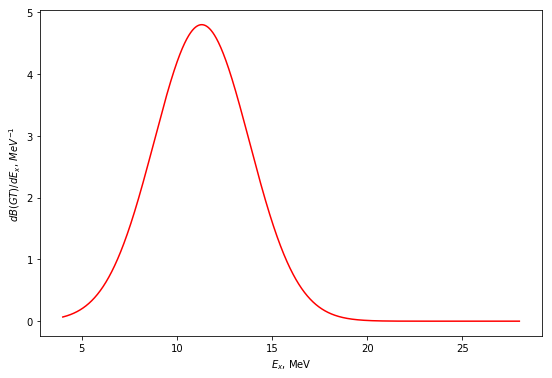

In [30]:
plt.figure(figsize=(9,6))
plt.plot(x_norm, y_norm, c='r')
plt.xlabel('$E_x$, MeV')
plt.ylabel("$dB(GT)/dE_x$, $MeV^{-1}$")

### Расчет

Некоторые константы

In [31]:
Q_EC_76As=0.9233 #in MeV
Z_76As=33

g_a_g_v=1.297 #ratio of vector and axial coupling constants

Функция для расчета порога реакции

In [32]:
def Q_k_func(E_k, Q_EC):
    #Считаем порог реакции, E_k - энергия возбужденного состояния в BGT
    #E_k in KeV
    return Q_EC+E_k/1000

Привиденная энергия вылетающего электрона: $\epsilon_e = \frac{E_{\nu}-Q_k}{m_e} + 1$

In [34]:
def e_e_func(E_nu, E_k, Q_EC):
    #Считаем привиденную энергию вылетающего электрона. Если энергия налетающего нейтрино E_nu
    #меньше порога, возвращаем 0 для обнуления итогового сечения
    #E_nu in MeV
    q=Q_k_func(E_k, Q_EC) #порог реакции
    if E_nu>q: return 1+(E_nu-q)/0.511
    else: return 0 

Привиденный импульс электрона: $\pi_e=\sqrt{\epsilon_e^2 -1}$

In [36]:
def Pi_e_func(e_e):
    #Привиденный импульс электрона, вычисляется через привиденную энергию; ** означает степень  
    if e_e>1: return math.sqrt(e_e**2 - 1)
    else: return 0

In [37]:
def integrate_func(a, b, x, y):
    return np.sum( np.interp(x=np.arange(a, b, 0.001), xp=x, fp=y ) * 0.001 )

### Fermi-function from Numerical Tables for Beta-Decay and Electron Capture

Ферми функия из оцифрованных немецких таблиц. Считываем данные

In [38]:
Fermi_func_new_data = pd.read_excel('../../fermi_func_tables/from_1968/13.xlsx')
Fermi_func_new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 14 columns):
P              49 non-null float64
F0L0           49 non-null float64
L0             48 non-null object
1z             48 non-null float64
13             48 non-null float64
ELECTRON
14    48 non-null float64
Z= 33
Izt      48 non-null float64
A= 77          48 non-null float64
A,             48 non-null float64
A2             48 non-null float64
VI2            48 non-null float64
912            48 non-null float64
12             48 non-null float64
Unnamed: 13    48 non-null float64
dtypes: float64(13), object(1)
memory usage: 5.4+ KB


Функция для расчета интерполированного значения. В таблице дана зависимость от импульса вылетающего электрона. Переводим ее в зав-ть от энергии электрона

In [39]:
e_e3 = np.sqrt( np.square( Fermi_func_new_data['P'].values ) + 1 ) #энергия вылетающего электрона
def num_tables_func(x):
    #x in units of mc^2
    return np.interp(x=x, xp=e_e3, fp=Fermi_func_new_data['F0L0'].values )

### B(GT) data

In [40]:
BGT=pd.read_csv('../B(GT) peaks processing//clear_B(GT).csv') #таблица со значениями B(GT)
BGT.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73 entries, 0 to 72
Data columns (total 5 columns):
Unnamed: 0        73 non-null int64
Ex                73 non-null float64
Jpi               73 non-null object
diff cross-sec    73 non-null float64
B(GT)             73 non-null float64
dtypes: float64(3), int64(1), object(1)
memory usage: 2.9+ KB


In [41]:
BGT['B(GT)'] = BGT['B(GT)']/10 #делим на 10 т.к. в таблице все значения домножены на 10

In [42]:
BGT = BGT[ BGT['Jpi'] == '1' ] #отбираем уравни с Jpi == 1

### BS05_OP flux

In [43]:
BS05_OP=pd.read_csv('../Vyborov_results/Fluxes/AllFluxes_BS05(OP).csv', sep=';')
BS05_OP.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 7 columns):
energy    2000 non-null float64
pp        2000 non-null float64
hep       2000 non-null float64
N         2000 non-null float64
F         2000 non-null float64
O         2000 non-null float64
B         2000 non-null float64
dtypes: float64(7)
memory usage: 109.5 KB


создаем словарь, где ключ - название канала нейтрино (напр O или F), значение - двумерный массив, характеризующий интеполированные значения энергии и амплитуды для даннаго канала нейтрино 

In [44]:
all_fluxes_step = 0.01
Energy_all_fluxes = np.arange(0,20,0.01) #массив характеризующий шаги интегрирования

In [45]:
BS05_OP_dict = {}
for elem in list(BS05_OP.columns)[1:]:
    BS05_OP_dict.update({ elem : 
                        np.interp(x=Energy_all_fluxes, xp=BS05_OP['energy'], 
                                  fp=BS05_OP[elem] ) })

### Cross-section and total rate

Сечение по Иджири $\sigma_k={(1.597\times10^{-44}\ cm^2)}\epsilon_e \pi_e m_e^2 F(Z,E_e) [B(F)_k + (\frac{g_a}{g_v})^2 B(GT)_k] $ 

In [49]:
g_a_g_v_square = math.pow(g_a_g_v,2)

In [50]:
#расчет сечения до энергии возбуждения 4 МэВ
def sigma_k_less4(E_nu, E_k, BGT_k, Z, Q_EC):
    #E_k in kev
    #сечение k-го возб. состояния по Иджири
    e_e=e_e_func(E_nu, E_k, Q_EC) #энергия вылетающего электрона
    Pi_e=Pi_e_func(e_e) #его импульс
    F_col=num_tables_func(e_e) #значение ферм-функции при такой энергии
    return e_e*Pi_e*F_col*g_a_g_v_square*BGT_k

In [51]:
#расчет сечения после энергии возбуждения 4 МэВ
def sigma_k_more4(E_nu, E_k, Z, Q_EC, BGT_more4):
    #WARNING: E_k in KeV 
    #сечение k-го возб. состояния по Иджири
    e_e=e_e_func(E_nu, E_k, Q_EC) #энергия вылетающего электрона
    Pi_e=Pi_e_func(e_e) #его импульс
    F_col=num_tables_func(e_e) #значение ферм-функции при такой энергии 
    return e_e*Pi_e*F_col*g_a_g_v_square*BGT_more4

In [52]:
#функция расчета свертки сечения с потоком
def rate_calc(BGT_x, BGT_y):
#метод Иджири, Ферми функция немцев, все возб. состояния
#sigma - массив со значениями суммарного сечения
    E_k_more4 = np.arange(4000,15000, 10)
    #список, каждое значение - интеграл B(GT) от 4 МэВ до значения энергии возбуждения
    BGT_more4_list = [integrate_func(4, E_k/1000, BGT_x, BGT_y) for E_k in E_k_more4] 
    
    sigma_less4=[sum([sigma_k_less4(E_nu, E_k, BGT_k, Z_76As, Q_EC_76As) 
                      for (BGT_k, E_k) in zip(BGT['B(GT)'].values, BGT['Ex'].values)]) 
                 for E_nu in Energy_all_fluxes]
    
    sigma_more4=[sum([sigma_k_more4(E_nu, E_k, Z_76As, Q_EC_76As, BGT_more4) 
                      for (E_k, BGT_more4) in zip(E_k_more4, BGT_more4_list)]) 
                 for E_nu in Energy_all_fluxes]
    
    const = math.pow(0.511,2)*1.597*math.pow(10,-44)
    
    
    
    sigma_total = ( np.array(sigma_less4) + np.array(sigma_more4) ) * const
    
    for elem in list(BS05_OP_dict.keys()):
        rate = sum(BS05_OP_dict[elem]*sigma_total*all_fluxes_step) * math.pow(10,36)
        print(elem, ' ', rate)
        
#ВНИМАНИЕ: в расчетах pep не учитывается

    Считаем свертку потока с сечением. 
    BS05_OP_dict[elem] - массив со значениями амплитуды потока нейтрино для канала elem.
    sigma - массив со значениями суммарного сечения.
    all_fluxes_step - шаг интегрирования.
    math.pow(10,36) - для получения итогового значения в SNU. 

In [53]:
rate_calc(x_norm, y_norm)

pp   0.0
O   0.827549244942
hep   11.6488679866
F   0.0210597366245
N   0.101981181764
B   564.803856734
